In [53]:
import pandas as pd

df=pd.read_json('https://gist.githubusercontent.com/farhaan-settyl/ecf9c1e7ab7374f18e4400b7a3d2a161/raw/f94652f217eeca83e36dab9d08727caf79ebdecf/dataset.json')

In [54]:
df.head()

externalStatus    internalStatus
0                                           PORT OUT          Port Out
1                                        TERMINAL IN  Inbound Terminal
2                                            PORT IN           Port In
3  Vessel departure from first POL (Vessel name :...         Departure
4  Vessel arrival at final POD (Vessel name : TIA...           Arrival

In [55]:
df.duplicated().sum()

1114

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   externalStatus  1222 non-null   object
 1   internalStatus  1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB


In [57]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1217     True
1218     True
1219     True
1220     True
1221     True
Length: 1222, dtype: bool

In [59]:
df.isna().sum()

externalStatus    0
internalStatus    0
dtype: int64

In [60]:
val=df.drop_duplicates(keep='last')
df.drop_duplicates(keep='first',inplace=True)

In [61]:
df['internalStatus'].value_counts()

internalStatus
Loaded on Vessel            49
Departure                   16
Arrival                     13
Outbound Terminal            9
Unloaded on Vessel           6
Empty Container Released     3
Inbound Terminal             2
Empty Return                 2
Gate Out                     2
Port Out                     1
Port In                      1
Gate In                      1
On Rail                      1
Off Rail                     1
In-transit                   1
Name: count, dtype: int64

In [62]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Output'] = label_encoder.fit_transform(df['internalStatus'])


In [63]:
!pip install tensorflow keras

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Tokenize and pad text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['externalStatus'])
X = tokenizer.texts_to_sequences(df['externalStatus'])
X = pad_sequences(X, maxlen=130)

In [65]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, df['Output'], test_size=0.2, random_state=21)


In [68]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=500, output_dim=130, ))
model.add(LSTM(64,return_sequences=True))
# model.add(Dropout(.4))
# model.add(LSTM(128,return_sequences=True))

# model.add(LSTM(64,return_sequences=True))

model.add(LSTM(32))

model.add(Dense(15, activation='softmax'))  # Adjust NUM_CLASSES based on the number of unique labels

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X, df['Output'], batch_size=8, epochs=40,callbacks=[early_stopping])



Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3202 - loss: 2.5867
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4352 - loss: 2.0302
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4686 - loss: 1.8514
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4216 - loss: 1.9061
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4400 - loss: 1.9818
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4202 - loss: 1.7554
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5126 - loss: 1.5873
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6220 - loss: 1.2311
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6476 - loss: 1.3413
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7196 - loss: 1.2569
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6830 - loss: 1.1752
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy:

In [82]:

def predict_internal_status(model, tokenizer, user_input):
    # Tokenize the user input
    import numpy as np
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    # Pad sequences to the same length as training data
    user_input_sequence_padded = pad_sequences(user_input_sequence, maxlen=130)

    # Make predictions
    predictions = model.predict(user_input_sequence_padded)

    # Get the predicted class (internal status)
    predicted_class = np.argmax(predictions)
    predicted_class1 = label_encoder.inverse_transform([predicted_class])

    return predicted_class1[0],np.max(predictions)
    # return predicted_class

In [83]:
predict_internal_status(model,tokenizer,' shiped')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


('Departure', 0.37551752)

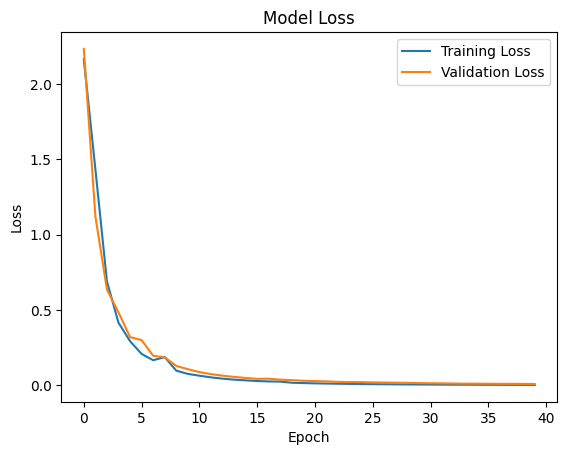

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming `history` is the variable containing the training history of the model
plot_loss(history)

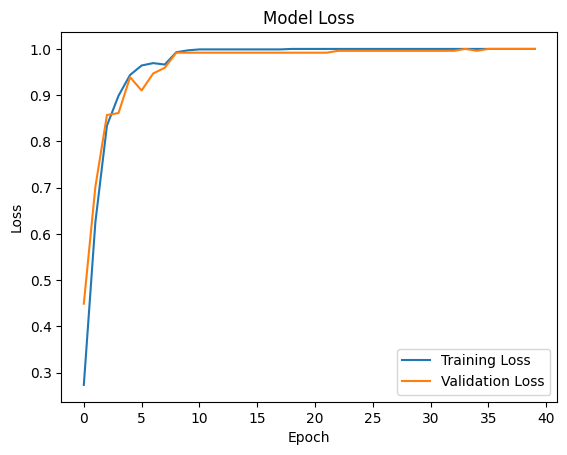

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Loss')
    plt.plot(history.history['val_accuracy'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming `history` is the variable containing the training history of the model
plot_accuracy(history)

In [97]:
model.save("model.keras")

In [98]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [99]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)